In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.simplefilter(action = "ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 170)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# TotalCharges sayısal bir değişken olmaslı
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")

df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


# Görev 1: KEŞİFÇİ VERİ ANALİZİ

## Adım 1: Genel resmi inceleyiniz.

In [7]:
def check_df(dataframe, head = 5):
    print("\n********** Shape **********")
    print(dataframe.shape)
    print("\n********** Types **********")
    print(dataframe.dtypes)
    print("\n********** Head **********") 
    print(dataframe.head(head))
    print("\n********** Tail **********")
    print(dataframe.tail(head))
    print("\n********** NA **********")
    print(dataframe.isnull().sum())
    print("\n********** Quantiles **********")
    numeric_df = dataframe.select_dtypes(include=['int', 'float'])
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [8]:
check_df(df)


********** Shape **********
(7043, 21)

********** Types **********
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

********** Head **********
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No     

## Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [11]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [12]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [13]:
cat_but_car

['customerID']

## Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.

In [14]:
# Kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("####################################")

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show()

In [15]:
for col in cat_cols:
    cat_summary(df, col)

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
####################################
         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
####################################
            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
####################################
              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
####################################
                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
####################################
                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                  

In [16]:
# Numerik değişkenlerin analizi
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins = 20)
        plt.xlabel(numerical_col)
        plt.ylabel(numerical_col)
        plt.show()

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


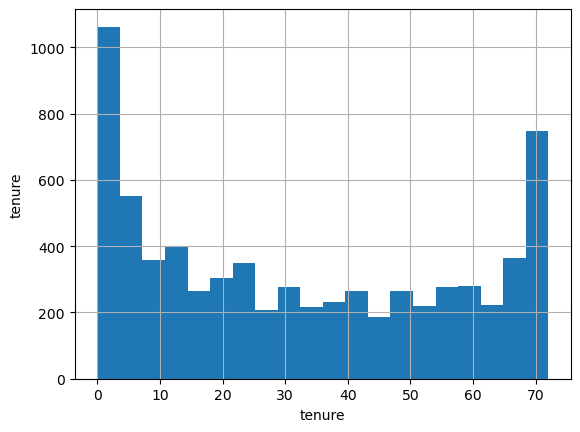

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


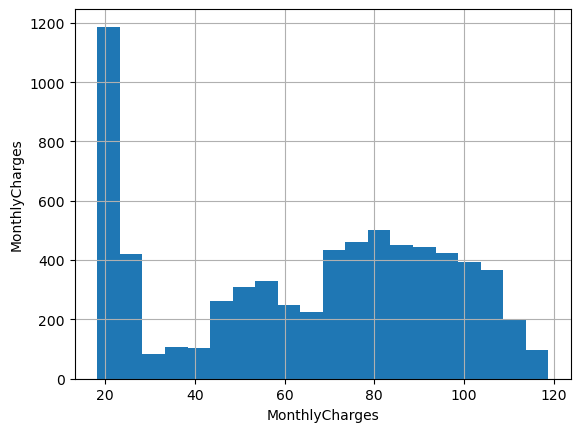

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


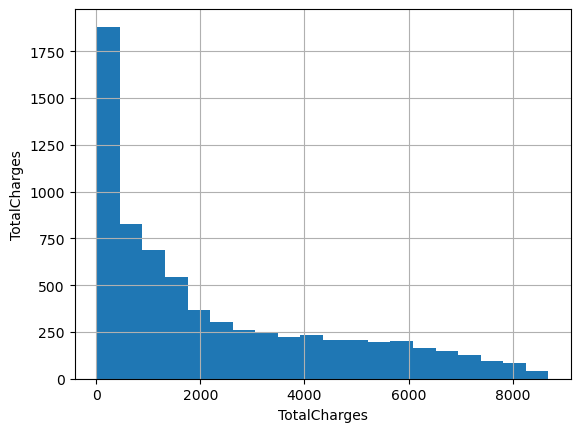

In [17]:
for col in num_cols:
    num_summary(df, col, plot = True)

## Adım 4: Hedef değişken analizi yapınız.

In [18]:
#Numerik değişkenlerin target'a göre analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end = "\n\n\n")

In [19]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




In [20]:
#Kategorik değişkenlerin target'a göre analizi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


In [21]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
                 TARGET_MEAN  Count  Ratio
InternetService                           
DSL                    0.19

## Adım 5: Korelasyon analizi yapınız.

In [22]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


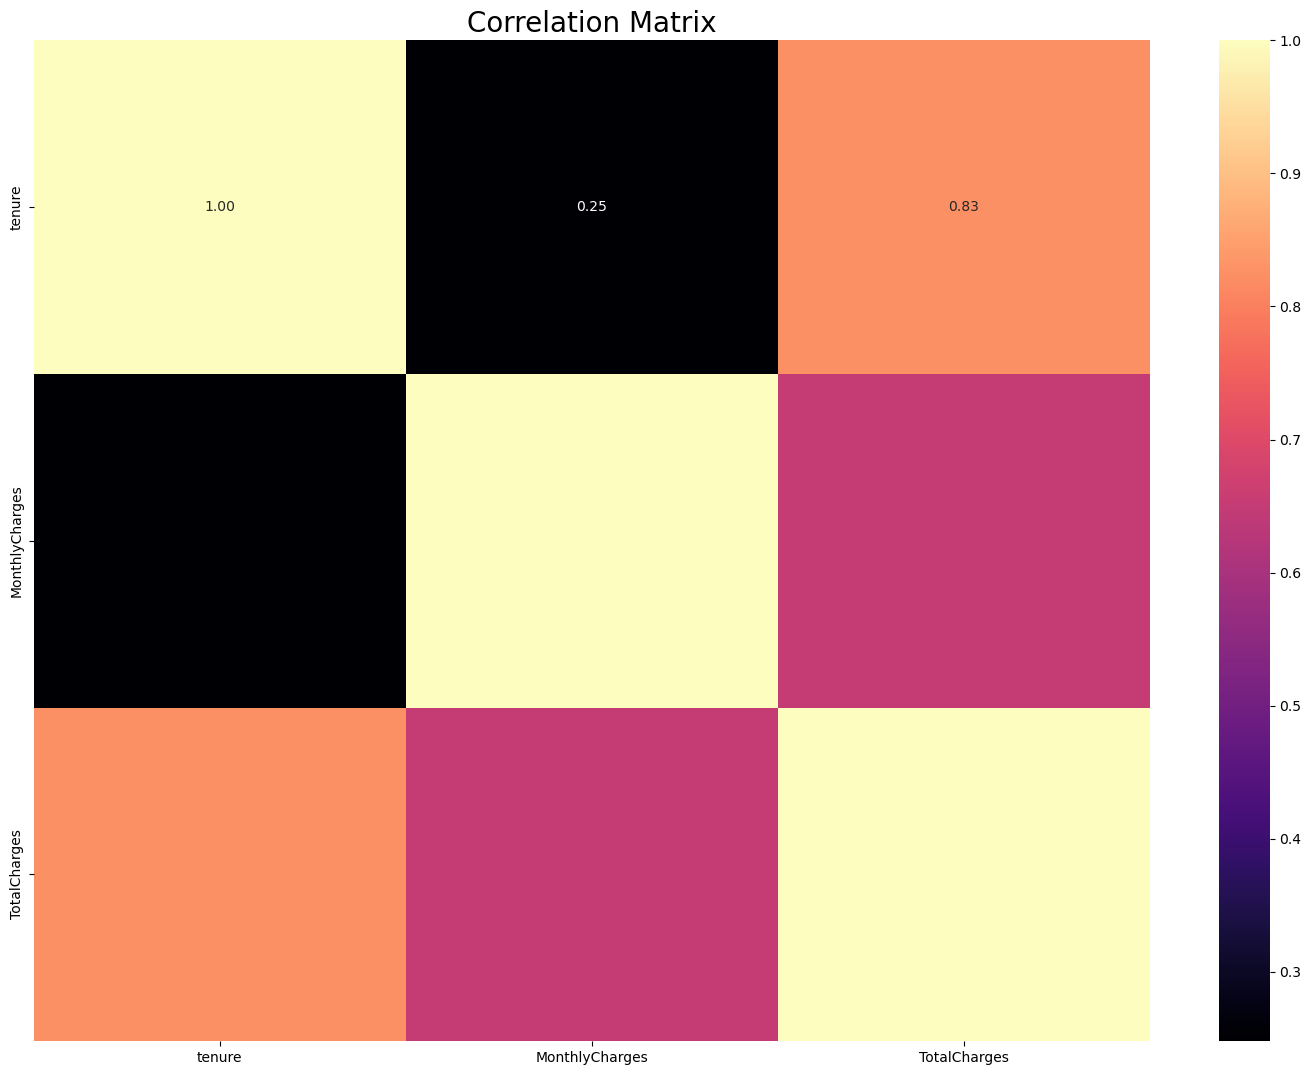

In [23]:
#Korelasyon matrisi
f, ax = plt.subplots(figsize = [18, 13])
sns.heatmap(df[num_cols].corr(), annot= True, fmt = ".2f", ax = ax, cmap = "magma")
ax.set_title("Correlation Matrix", fontsize = 20)
plt.show()

In [24]:
# Bağımlı değişken özelinde korelasyona bakalım
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.corrwith(df["Churn"]).sort_values(ascending= False)

Churn             1.000
MonthlyCharges    0.193
SeniorCitizen     0.151
TotalCharges     -0.199
tenure           -0.352
dtype: float64

# Görev 2: Feature Engineering

## Adım 1:  Eksik ve aykırı değerler için gerekli işlemleri yapınız.

In [25]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [26]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [27]:
na_columns = missing_values_table(df, na_name= True)
na_columns

              n_miss  ratio
TotalCharges      11  0.160


['TotalCharges']

In [28]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace = True)

In [29]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [30]:
# Base model kuralım
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [31]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [32]:
dff = one_hot_encoder(df, cat_cols, drop_first= True)

In [33]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1
0,7590-VHVEG,1,29.850,29.850,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
1,5575-GNVDE,34,56.950,1889.500,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2,3668-QPYBK,2,53.850,108.150,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
3,7795-CFOCW,45,42.300,1840.750,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
4,9237-HQITU,2,70.700,151.650,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


In [34]:
y = dff["Churn"]
X = dff.drop(["Churn", "customerID"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [35]:
catboostmodel = CatBoostClassifier(verbose = False, random_state= 12345).fit(X_train, y_train)
y_pred = catboostmodel.predict(X_test)

In [36]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")


Accuracy: 0.7847
Recall: 0.6331
Precision: 0.493
F1: 0.5544
Auc: 0.7292


In [37]:
# Şimdi de aykırı değerler üzerine çalışalım.
def outlier_tresholds(dataframe, col_name, q1 = 0.05, q3 = 0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)

    interquantile_range = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    return low_limit, up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_tresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [38]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


## Adım 2: Yeni değişkenler oluşturunuz.

In [39]:
# Tenure değişkenini yıllara göre kategorik değişkenlere bölelim.
df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_ENGAGED"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_NO_PROTECTION"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes")
                                   or (x["TechSupport"] != "Yes") else 0, axis = 1)

# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_YOUNG_AND_NOT_ENGAGED"] = df.apply(lambda x: 1 if (x["NEW_ENGAGED"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis = 1)

# Kişinin toplam aldığı servis sayısı
df["NEW_TOTAL_SERVICES"] = (df[["PhoneService", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
                               "StreamingTV", "StreamingMovies"]] == "Yes").sum(axis = 1)

# Herhangi bir streaming hizmeti olanlar
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis = 1 )

# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AUTOPAYMENT"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# Ortalama aylık ödeme
df["NEW_AVG_CHARGES"] = df["TotalCharges"] / (df["tenure"] + 1) # tenure değeri 0 olanlar da var. Belirsizlik hatası vermemesi için +1 yazdık

# Güncel fiyatın ortalama fiyata göre artışı
df["NEW_INCREASE"] = df["NEW_AVG_CHARGES"] / df["MonthlyCharges"]

# Servis başına ücret
df["NEW_AVG_SERVICE_FEE"] = df["MonthlyCharges"] / (df["NEW_TOTAL_SERVICES"] + 1)

In [40]:
df.shape

(7043, 31)

In [41]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_ENGAGED,NEW_NO_PROTECTION,NEW_YOUNG_AND_NOT_ENGAGED,NEW_TOTAL_SERVICES,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AUTOPAYMENT,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


## Adım 3:  Encoding işlemlerini gerçekleştiriniz.

In [42]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


In [43]:
# Label encoding
def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe

In [44]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [45]:
for col in binary_cols:
    label_encoder(df, col)

In [46]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn","NEW_TOTAL_SERVICES"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_ENGAGED',
 'NEW_NO_PROTECTION',
 'NEW_YOUNG_AND_NOT_ENGAGED',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AUTOPAYMENT']

In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns= categorical_cols, drop_first= drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first = True)

In [48]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TOTAL_SERVICES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_ENGAGED_1,NEW_NO_PROTECTION_1,NEW_YOUNG_AND_NOT_ENGAGED_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,14.925,0.500,14.925,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,36.050,0.669,13.463,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,50.550,0.715,35.350,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False


In [49]:
df.shape

(7043, 46)

## Adım 4: Numerik değişkenler için standartlaştırma yapınız.

In [50]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [51]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TOTAL_SERVICES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_ENGAGED_1,NEW_NO_PROTECTION_1,NEW_YOUNG_AND_NOT_ENGAGED_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,7590-VHVEG,0,1,0,-1.277,0,1,-1.160,-0.994,0,1,-0.758,-0.238,-0.311,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False
1,5575-GNVDE,1,0,0,0.066,1,0,-0.260,-0.173,0,3,-0.118,-0.010,-0.410,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False
2,3668-QPYBK,1,0,0,-1.237,1,1,-0.363,-0.960,1,3,-0.412,-0.152,-0.522,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False
3,7795-CFOCW,1,0,0,0.514,0,0,-0.747,-0.195,0,3,-0.347,-0.011,-0.939,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True
4,9237-HQITU,0,0,0,-1.237,1,1,0.197,-0.940,1,1,-0.174,-0.129,2.636,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False


## Adım 5: Model oluşturunuz.

In [52]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [53]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [54]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.65
Precision: 0.5
F1: 0.56
Auc: 0.74


In [55]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #dictionary kullanarak dataframe oluşturma
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    f1_df = pd.DataFrame(data)

    # dataframe içindeki özellikleri en önemliden önemsize göre sıralama
    f1_df.sort_values(by = ["feature_importance"], ascending = False, inplace = True)

    # Şimdi bir barplot grafiği oluşturalım
    plt.figure(figsize= (15,10))
    sns.barplot(x = f1_df["feature_importance"], y = f1_df["feature_names"])

    plt.title(model_type + " FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

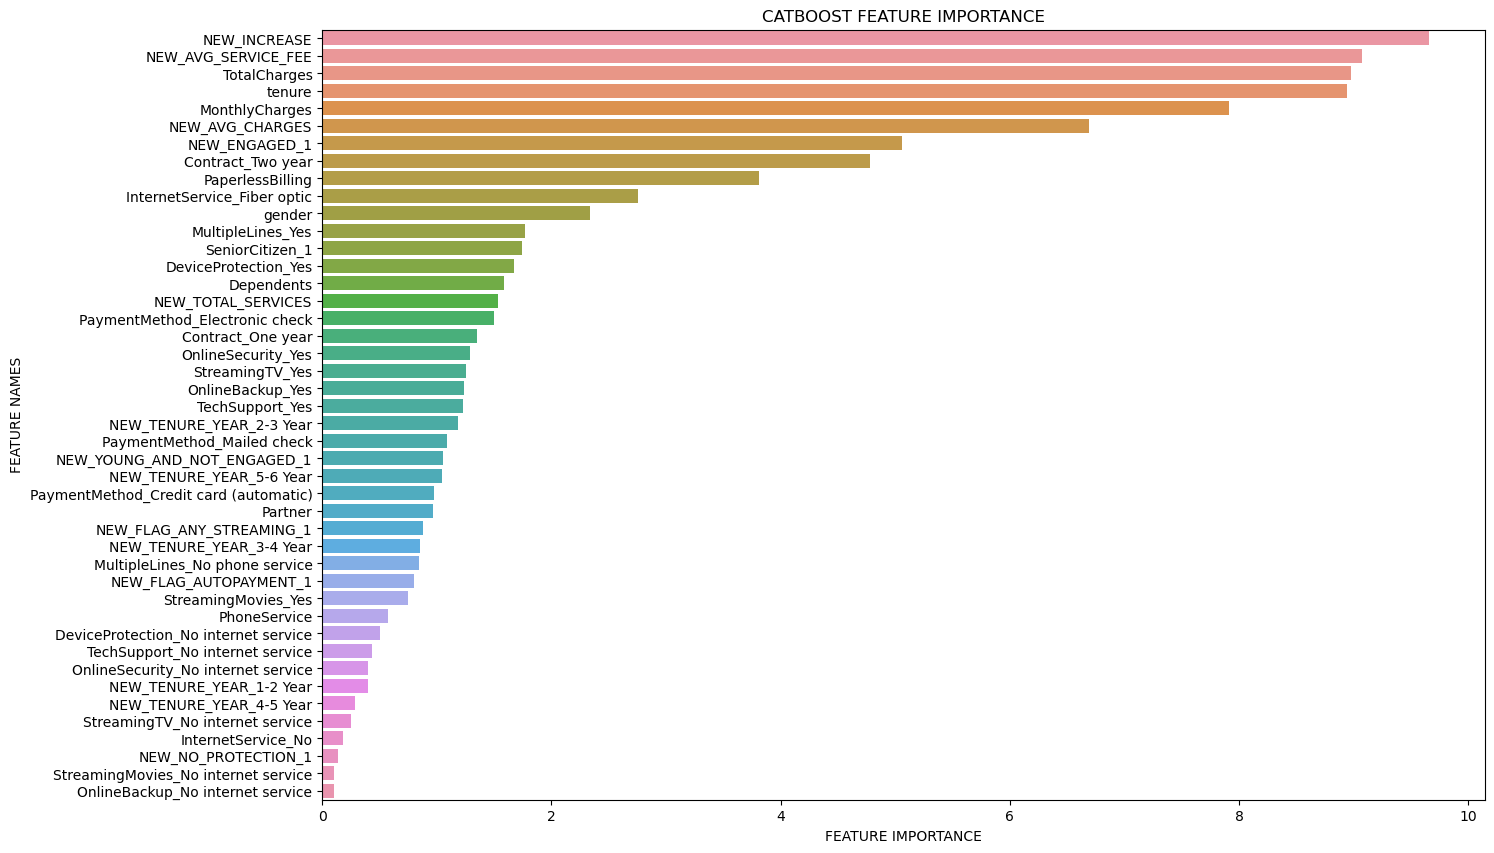

In [56]:
plot_feature_importance(catboost_model.get_feature_importance(), X.columns, "CATBOOST")

DEMEK Kİ FEATURE ENGINEERING ÖNEMLİ BİR KONU :)